# Wind Farm Test
In this file, one can test certain wind farm layouts and configurations. Some basic functions are demonstrated. With the resulting turbine power outputs and flowfields, one can make their own comparisons between farms.

### Import libraries
Here, the libraries used in this file are imported. Distinctions are made between already existing libraries, custom libraries specially made for TouchWind wind farm simulation and optimization, and the models used at TouchWind.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
from scipy import optimize

# Import custom libraries
import functions as func
import visualization as viz
import optimization as opt
from optimization import Optimization
from cases import (
    Case,
    CaseManager,
)

# Import models
from models.LES import LES
from models.CCM import CCM
from models.TestModel import TestModel

# Get some of the most beautiful color schemes you've ever seen
colors, colorgrad = viz.get_color_schemes()

### Choose model
Here, models can be chosen to use for running simulations here in Python (`model`) and which models are used as reference (`ref_model`). An instance of a model should be set. Currently, models that can be used for modeling in Python are: `CCM()`. For reference, models that can be used are: `LES()`.

In [2]:
model = CCM()
ref_model = LES()

### Create case manager
Here, an instance the class `CaseManager` is created, names `test_casemanager`. This case manager can load cases from a .csv file, in this case from "test_cases.csv". With masks, certain cases from this .csv file can be excluded. Case managers can be used to quickly loop over several related cases, which can come in use during optimization or when comparing cases with reference data. Several case managers can be created next to each other, for different purposes.

At the end of this cell, all case names are printed, which can be used to select single cases further on in this notebook.

In [3]:
# Add new case
test_casemanager = CaseManager(
    name='Test Case Manager',
    ref_model=ref_model,
    ref_data_location='../LES/',
    ref_standard_case='1TURB_wd270_ws10_1x_y0_t5',
)

# Set masks to select cases from .csv file
masks = {
    'test': 1,
    'optimization': 1,
}

# Load csv files
test_casemanager.load_csv_cases(
    location='../TouchWind_Optimization_Framework/',
    file_name='test_cases.csv',
    masks=masks,
)

# Print all case names
for name in test_casemanager.case_names:
    print(name)

1x1TURB_wd270_ws10_1x_y0_t5
2x2TURB_wd270_ws10_4x_y0_t5
3TURB_wd270_ws10_3x_y0_t-30
3x3_optimization_test
6x6_optimization_test


### Create custom case
Here, a custom case is created. First, an instance of class `Case` is made, whhich is named `custom_case_1`. 

Next the wind `conditions` of this case are set. These conditions include:
- `directions`      (array with wind directions)
- `speeds`          (array with wind speeds)
- `TI`              (array with turbulent intensities)
- `ABL_params`      (dictionary containing parameters to create streamwise and spanwise velocity profiles)

After that, the farm `layout` of this case is set. This includes:
- `shape`           (the shape of the farm layout, either "rectangular", "hexagonal", or "custom")
- `n_x`             (number of turbines in the x-direction)
- `n_y`             (number of turbines in the y-direction)
- `spacing_x`       (turbine spacing [D] in the x-direction)
- `spacing_y`       (turbine spacing [D] in the y-direction)
- `D_rotor`         (rotor diameter [m])
- `x_i`             (turbine x-coordinates [m], in case of custom shape)
- `y_i`             (turbine y-coordinates [m], in case of custom shape)

Lastly, the settings of all `turbines` are set. These include:
- `yaw_i`           (array of with yaw angles [degrees] of all turbines)
- `tilt_i`          (array of with tilt angles [degrees] of all turbines)
- `thrustcoef_i`    (array of with thrust coefficients [-] of all turbines)

In [4]:
# Create instance of case
custom_case_1 = Case(
    name='custom_case_1',
)

# Set conditions
custom_case_1.set_conditions(
    directions=np.array([270]),
    speeds=np.array([10]),
    TI=np.array([0.06]),
    ABL_params=None,
)

# Set wind farm layout
custom_case_1.set_layout(
    shape='rectangular',
    n_x=4,
    n_y=5,
    spacing_x=5,
    spacing_y=5,
    D_rotor=126,
    x_i=None, 
    y_i=None,
)

# Set turbine properties
custom_case_1.set_turbines(
    yaw_i=np.ones((1, 1, custom_case_1.layout['n_turbines'])) * 0,
    tilt_i=np.ones((1, 1, custom_case_1.layout['n_turbines'])) * 0,
    thrustcoef_i=np.ones((1, 1, custom_case_1.layout['n_turbines'])) * 1,
)

### Run single case
Here, a single case is calculated, by calling the `run(case)` function of the `model`. The total power is printed, the farm layout is vizualized and the powers of all turbines are visualized.

Total power:    39.50000000000001 MW


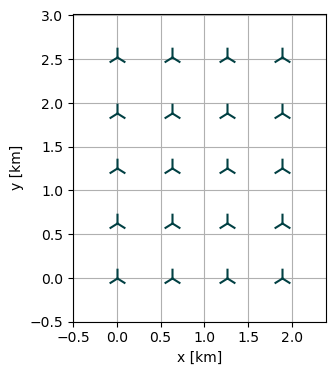

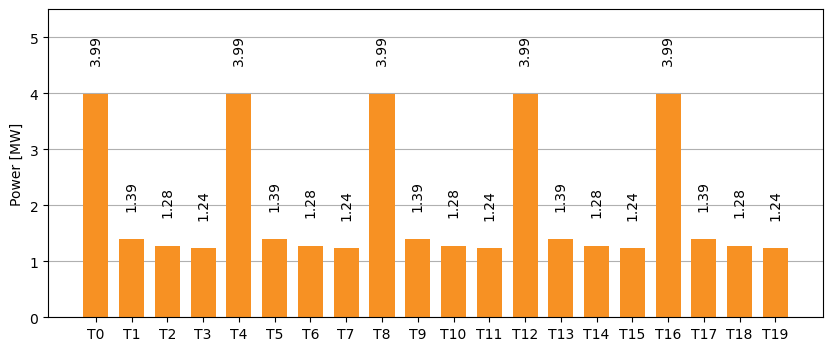

In [5]:
# Run case and plot layout and powers
turbine_powers = model.run(
    custom_case_1,
)

# Print total power in MW
print(f'Total power:    {np.sum(np.round(turbine_powers/1e6, 2))} MW')

# Visualize farm layout
viz.plot_farm_layout(
    custom_case_1.layout['x_i'],
    custom_case_1.layout['y_i']
);

# Visualize turbine powers
viz.plot_turbine_powers(
    turbine_powers[0, 0],
    figsize=(10, 4),
);

### Run cases of casemanager
Here the cases in case manager are calculated. This is done by extracting the cases from the manager and looping over the cases. The powers of all turbines are visualized.

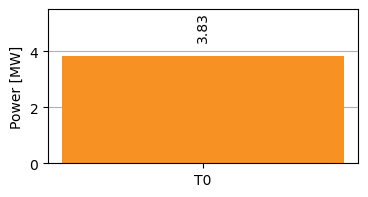

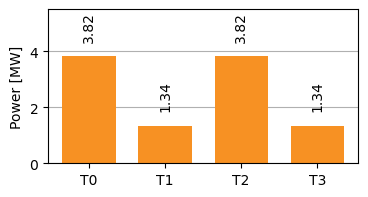

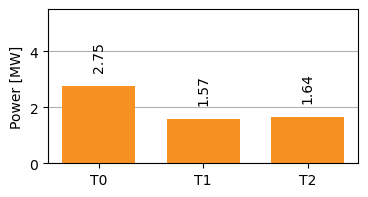

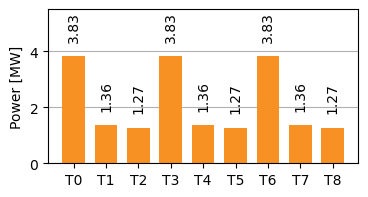

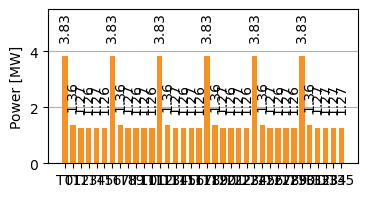

In [6]:
# Extract cases from casemanager
cases = test_casemanager.get_cases()

# Loop over all cases and run cases
for case in cases:
    turbine_powers = model.run(
        case
    )

    # Visualize turbine powers
    viz.plot_turbine_powers(turbine_powers[0, 0], figsize=(4, 2))

### Plot velocity field
Here the velocity field is plotted for the X, Y and Z plane. The function `plot_velocity_field` contains many options. If you hoover over the function, one can read what are options in the function are. Note that in the X plane, the x-axis, representing the y-direction is inverted to be consistent with the farm layout.

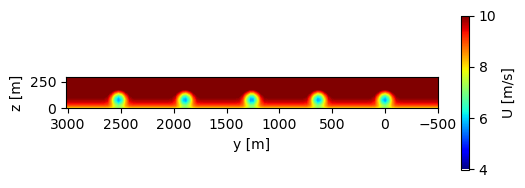

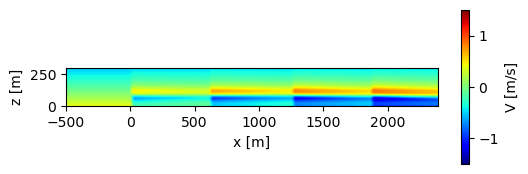

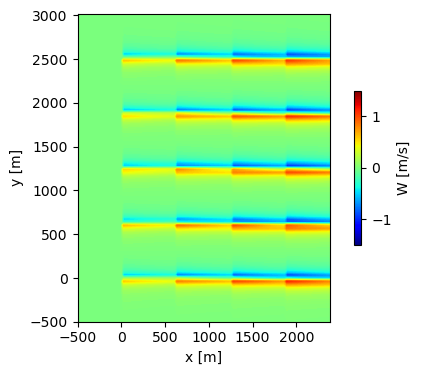

In [7]:
# Plot streamwise velocity component in X plane
viz.plot_velocity_field(
    model,
    custom_case_1,
    component='U',
    plane='X',
);

# Plot spanwise velocity component in Y plane
viz.plot_velocity_field(
    model,
    custom_case_1,
    component='V',
    plane='Y',
);

# Plot vertical velocity component in Z plane
viz.plot_velocity_field(
    model,
    custom_case_1,
    component='W',
    plane='Z',
);

### Optimization
Here, the optimization framework is deployed. A lot of code is left in, since many things can be changed when running the optimization. The preperation steps are described below:

1. Select the case to optimize and create a deepcopy of it to not accidently modify it.
2. Select the parameters to optimize. Currently, yaw, tilt and the thrust coefficient can be optimized.
3. Set location and file name of results .csv file
4. Select optimization algorithm and set its options. Important options are `tolerance`; the tolerance for termination, and `maxiter`; the maximum number of iterations before automatic termination.
5. Set the wind directions and wind direction uncertainty parameters. Here `exclude_range` indicates in which range wind turbines are indicated as downwind. `n_discretized_wds` indicates the number of wind directions to take into account in the wind direction uncertainty method, this should preferably be an odd number to include the current wind direction itself. A larger number means the optimization takes longer. `sigma_wd` [degrees] indicates the standard deviation for the wind direction uncertainty distribution.
6. Set the wind turbine properties, where `bounds` indicate the boundaries of the optimization parameters, `guesses` indicate the initial guess the optimization algorithm applies, and `downwind_values` indicate the properties for downwind turbines. The value for the trust coefficient for downwind turbines has to be set to 1, to ensure the thrust coefficient is based on the wind speed instead of it being set to a suboptimal value.
7. Get the total number of wind turbines
8. Initialize the optimization results dataframe with the function `get_optimization_dataframe()`. This function automatically detects if there is already an existing file, so optimization can be paused and started again, while using the same results file.
9. Get downwind masks for all wind directions, ensuring the optimization algorithm only has to optimize wind turbine properties of upwind turbines. This reducing the number of dimensions of the optimization problem and therefore the time required of the optimization algorithm to find an optimal parameter set.
10. Get a list of dictionaries, one for each wind direction, which holds all optimizable parameter names, boundaries and guesses.
11. Get the conventional total power for all wind directions, to be used for a penalty in the cost function when the total power is lower than the conventional power. This penalty can be used, since we know the maximum total power achievable is at least equal or higher than the conventional total power.

The actual optimization algorithm steps are described below:

12. Loop over all wind directions. This can be parallelized in the future, since in results for different wind directions are in principle unrelated to each other, and the wind direction uncertainty method accounts for slight alterations in directions.
13. Get the wind direction specific optimizable parameters with their boundaries and initial guesses.
14. Create an instance of the class `Optimization()`, where all optimization settings and wind direction specific settings are given as input.
15. Run the optimization algorithm, by minimizing the cost function as defined in previously defined instance of class `Optimization`: `optimization.cost_function()`.
16. Extract optimized parameters from results.
17. Get the complete set of wind turbine parameters, combining the optimization results with downwind values for downwind turbines.
18. Get the total power and individual turbine powers
19. Save all data in a dictionary.
20. Add the data to the optimization dataframe, and save it in a .csv file. When parallelized, one should take care of this part, since at this point data from different wind directions comes together. Therefore, it must be ensures that no data is accessed sequentially.
21. Print some nice progress information.

In [8]:
# Select case for optimization
case_name = '3x3_optimization_test'
optimization_case = copy.deepcopy(test_casemanager.cases[case_name])

# Select parameters to optimize
optimization_parameters = [
    'yaw',
    'tilt',
    # 'thrustcoef',
]

# Set location and file name of resulting data
result_location = '../Optimization Results/'
result_filename = f'{case_name}.csv'

# Set optimization algorithm settings
method = 'SLSQP'
penalty = True
options = {
    'disp': True,
    'maxiter': 100,
    'eps': None,
}
tolerance = 1e-3

# Set wind directions and uncertainty parameters
wind_directions = np.linspace(225, 312, 30)
# wind_directions = np.linspace(270, 300, 2)
wind_speeds = np.linspace(10, 10, 1)
exclude_range = 120
n_discretized_wds = 7
sigma_wd = 5.25

# Set wind turbine properties
bounds = {
    'yaw': (-40, 40),
    'tilt': (-50, -5),
    'thrustcoef': (0.01, 0.99),
}
guesses = {
    'yaw': 0,
    'tilt': -5,
    'thrustcoef': 1,    
}
downwind_values = guesses
# NOTE: Downwind value of thrust coefficient must be 1
downwind_values['thrustcoef'] = 1

# Get number of turbines
n_turbines = optimization_case.layout['n_turbines']

# Initialize dataframe for wind farm data
df_optimization = opt.get_optimization_dataframe(
    result_location,
    result_filename,
    optimization_parameters,
    optimization_case.layout,
)

# Get downwind mask for all wind directions
downwind_masks = func.get_downwind_masks(
    wind_directions,
    optimization_case.layout,
    exclude_range,
)

# Get parameter names, bounds and guesses dictionaries corresponding with result lists
result_bounds_guess_dicts = opt.get_result_bounds_guess_dicts(
    optimization_parameters,
    downwind_masks,
    bounds,
    guesses,
)

# TODO: Get conventional total powers
turbine_powers_conv = opt.get_turbine_powers_conv(
    model,
    optimization_case,
    wind_directions,
    downwind_values,
)
total_powers_conv = np.sum(turbine_powers_conv, axis=2)[:, 0]

# Start optimization framework
start_time = time.time()

# Loop over all wind directions
for idw, wd in enumerate(wind_directions):

    # Get lists of parameter names, bounds and guesses
    dictionary = result_bounds_guess_dicts[idw]
    parameter_names = list(dictionary.keys())
    parameter_bounds = [i[0] for i in list(dictionary.values())]
    parameter_guesses = [i[1] for i in list(dictionary.values())]

    # Initialize optimization class for wind direction
    optimization = Optimization(
        model=model,
        case=optimization_case,
        wd=wd,
        vars=optimization_parameters,
        mask=downwind_masks[idw],
        method=method,
        penalty=penalty,
        total_power_conv=total_powers_conv[idw],
        downwind_values=downwind_values,
        n_discretized_wds=n_discretized_wds,
        sigma_wd=sigma_wd,
    )

    # Run optimization algorithm
    start_time_wd = time.time()

    result = optimize.minimize(
        fun=optimization.cost_function,
        x0=parameter_guesses,
        tol=tolerance,
        bounds=parameter_bounds,
        options=options,
    )

    end_time_wd = time.time()

    # Get optimized wind turbine parameter set
    parameters_optimized = result.x

    # Get complete wind turbine parameter set
    all_parameters = opt.get_all_parameters(
        n_turbines,
        parameter_names,
        parameters_optimized,
        optimization_parameters,
        downwind_values,
    )

    # Get total power and turbine powers
    total_power = optimization.total_power
    turbine_powers = optimization.turbine_powers

    # Save wind farm data in new row dictionary
    dict_new_row =  all_parameters.copy()
    dict_new_row['wind_direction'] = wd
    dict_new_row['total_power'] = total_power
    dict_new_row['total_power_conv'] = total_powers_conv[idw]
    dict_new_row['time'] = end_time_wd - start_time_wd
    dict_new_row['success'] = result.success
    dict_new_row['message'] = result.message
    dict_new_row['n_iterations'] = result.nit
    dict_new_row['function_values'] = optimization.function_values
    dict_new_row['result'] = result
    
    for turb in range(n_turbines):
        dict_new_row[f'power_{turb}'] = turbine_powers[turb]
    
    # Add new row to dataframe
    df_new_row = pd.DataFrame([dict_new_row])
    df_optimization = pd.concat([df_optimization, df_new_row], ignore_index=True)
    
    # Save optimization data
    df_optimization.to_csv(result_location + result_filename, index=False)

    # Print progress and estimated time
    opt.print_progress(
        start_time,
        idw,
        wind_directions,
    )

# TODO save settings in txt file

Progress: 100.0 %
    Mean time per optimization run: 0.0 minutes
    Estimation: 0 minutes remaining
    Currently at wind direction 312.0 (30 of 30)


### Optimization visualization
In the following cells, data of the optimization is visualized. This includes data about the actual improvement in power output compared to conventional setups and data about the convergence, time and number of model evaluations / iterations per wind direction. Use these plots to create your own necesarry plots or to quickly analyze the optimization.

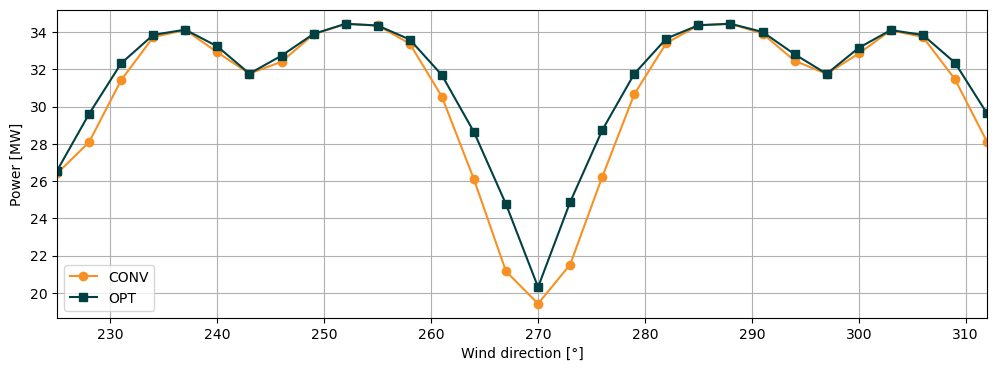

In [15]:
# Plot of conventional and optimized total power
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['total_power_conv']/1e6, color=colors[0], label='CONV', marker='o')
ax.plot(df_optimization['wind_direction'], df_optimization['total_power']/1e6, color=colors[1], label='OPT', marker='s')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Power [MW]')
ax.grid()
ax.legend()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


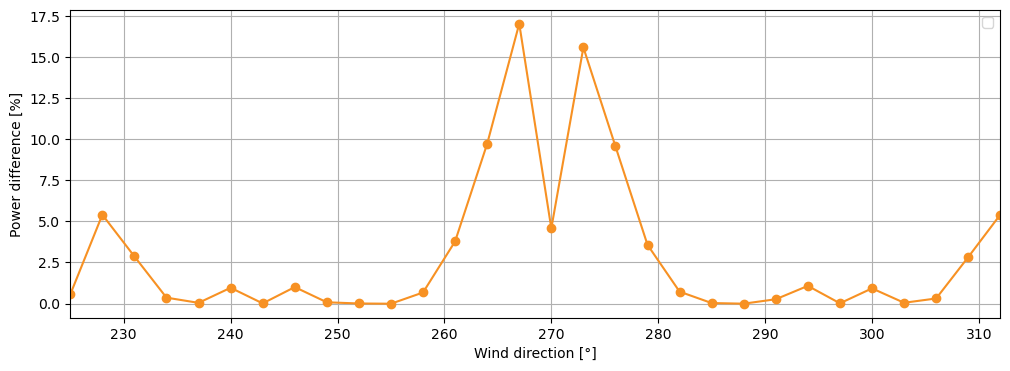

In [16]:
# Plot of relative total power increase
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    df_optimization['wind_direction'], 
    (df_optimization['total_power'] - df_optimization['total_power_conv']) / df_optimization['total_power_conv'] * 100, 
    color=colors[0], marker='o'
)
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Power difference [%]')
ax.grid()
ax.legend()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

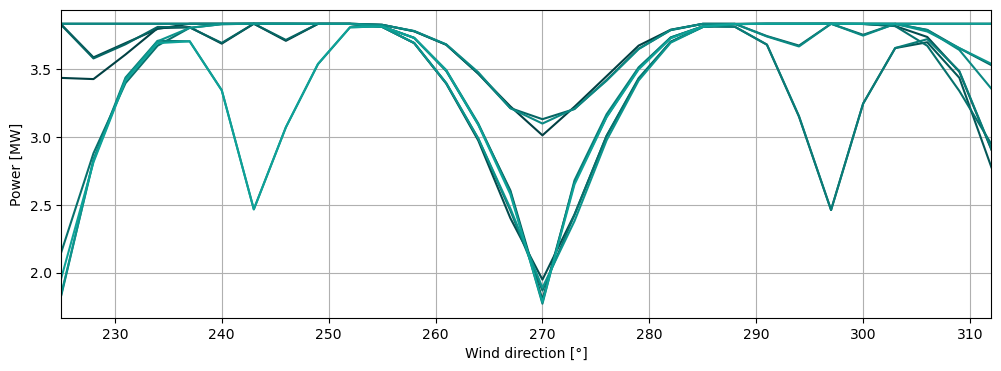

In [22]:
# Plot of power, yaw, tilt or thrustcoefficient of all turbines
value = 'power' # 'yaw', 'tilt', 'thrustcoef'

fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
for turb in range(n_turbines):
    if value == 'power':
        ax.plot(df_optimization['wind_direction'], df_optimization[f'{value}_{turb}']/1e6, color=colorgrad[turb%len(colorgrad)])
    else:
        ax.plot(df_optimization['wind_direction'], df_optimization[f'{value}_{turb}'], color=colorgrad[turb%len(colorgrad)])
ax.set_xlabel('Wind direction [°]')
if value == 'power':
    ax.set_ylabel('Power [MW]')
elif value == 'yaw':
    ax.set_ylabel('Yaw angle [°]')
elif value == 'tilt':
    ax.set_ylabel('Tilt angle [°]')
elif value == 'thrustcoef':
    ax.set_ylabel('Thrust coefficient [-]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

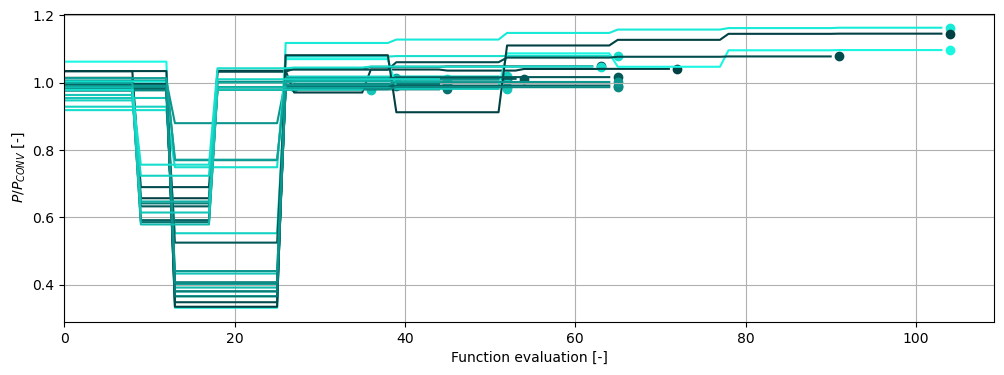

In [14]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
for i in range(len(df_optimization)):
    values = df_optimization['function_values'].iloc[i] / df_optimization['total_power_conv'][i]
    ax.plot(values, color=colorgrad[i%len(colorgrad)])
    ax.scatter(len(values), values[-1], color=colorgrad[i%len(colorgrad)])
ax.set_xlabel('Function evaluation [-]')
ax.set_ylabel('$P/P_{CONV}$ [-]')
ax.grid()
ax.set_xlim(0,)
plt.show()

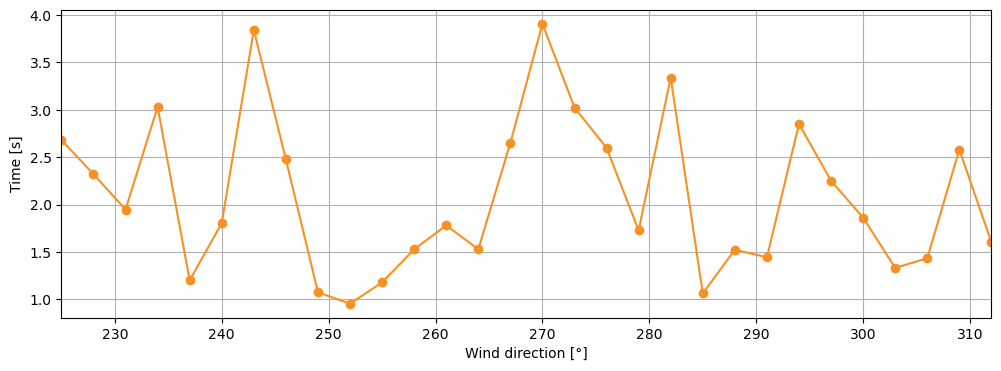

In [14]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['time'], color=colors[0], marker='o')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Time [s]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

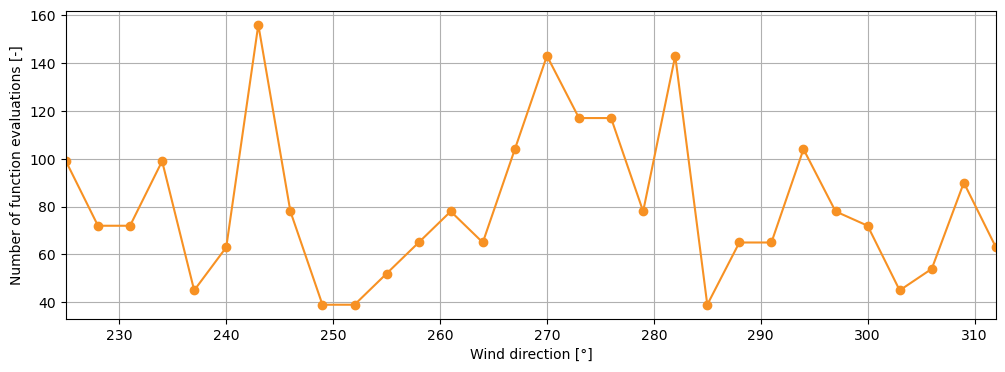

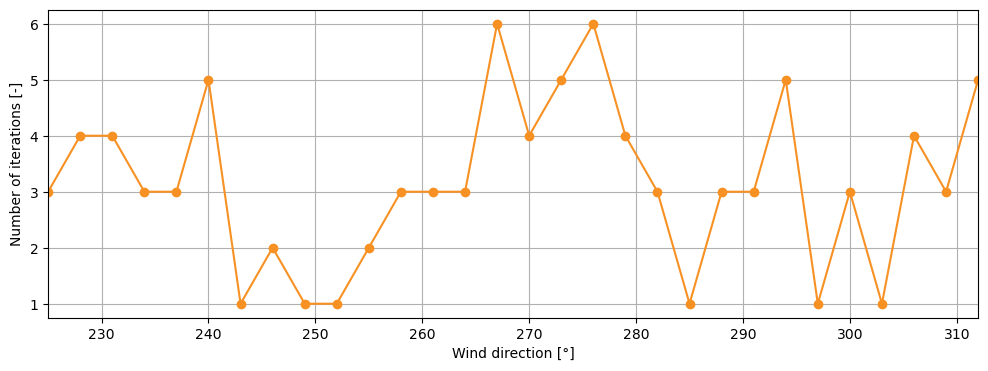

In [15]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], [len(i) for i in df_optimization['function_values']], color=colors[0], marker='o')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Number of function evaluations [-]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['n_iterations'], color=colors[0], marker='o')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Number of iterations [-]')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()